<a href="https://colab.research.google.com/github/wahid028/Sentiment-Analysis/blob/main/sentiment_analysis_using_BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install kaggle
!pip install -q kaggle

#upload the kaggle.json file
from google.colab import files
files.upload()

#create a kaggle directory
!mkdir ~/.kaggle

#copy the kaggle.json to kaggle directory
!cp kaggle.json ~/.kaggle/

#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c tweet-sentiment-extraction

 72% 1.00M/1.39M [00:01<00:00, 964kB/s]
100% 1.39M/1.39M [00:01<00:00, 1.34MB/s]


In [3]:
!unzip tweet-sentiment-extraction.zip

Archive:  tweet-sentiment-extraction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install nltk
! pip install spacy
! pip install beautifulsoup4
! pip install regex

In [ ]:
!pip install transformers

In [12]:
# !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [136]:
#print bold text
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import nltk
import spacy
import re
from bs4 import BeautifulSoup
nltk.download("all")

import torch
import tensorflow as tf
import gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


from transformers import AutoTokenizer
from transformers import BertTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [49]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [50]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [91]:
df = pd.read_csv('../content/train.csv')

In [92]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [93]:
# drop the rows with neutral sentiment as we are only interested in positive and negative sentiment
df = df[df['sentiment'] != 'neutral']
df = df.reset_index(drop=True)

In [94]:
df = df[['text','sentiment']]

In [95]:
#sentiment converter
def sentiment_ts(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'positive':
        return 1
    
df['label'] = df['sentiment'].apply(sentiment_ts)

In [96]:
df.head()

,text,sentiment,label
0,Sooo SAD I will miss you here in San Diego!!!,negative,0
1,my boss is bullying me...,negative,0
2,what interview! leave me alone,negative,0
3,"Sons of ****, why couldn`t they put them on t...",negative,0
4,2am feedings for the baby are fun when he is a...,positive,1


In [97]:
df = df[['text','label']]

Text Pre-processing

In [44]:
#load the spacy model and functions related to stop words modification
spacy_model = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
# print(spacy_model.Defaults.stop_words) #print the default stop words list
# spacy_model.Defaults.stop_words.remove("whatever") #remove single stop word from the list
# spacy_model.Defaults.stop_words -= {"whatever", "whenever"} #remove several stop words from the list
spacy_model.Defaults.stop_words.add("4am") #add single stop word in the default list
# spacy_model.stop_words |= {"my_new_stopword1","my_new_stopword2"} #add several stop words in the default list

In [45]:
#most widely used shortforms are in the internet for social media data
contra_Expan_Dict = {
"ain`t": "am not","aren`t": "are not","can`t": "cannot","can`t`ve": "cannot have","`cause": "because",
"could`ve": "could have","couldn`t": "could not","couldn`t`ve": "could not have","didn`t": "did not",
"doesn`t": "does not","don`t": "do not","hadn`t": "had not","hadn`t`ve": "had not have","hasn`t": "has not",
"haven`t": "have not","he`d": "he would","he`d`ve": "he would have","he`ll": "he will","he`ll`ve": "he will have",
"he`s": "he is","how`d": "how did","how`d`y": "how do you","how`ll": "how will",
"how`s": "how does","i`d": "i would","i`d`ve": "i would have","i`ll": "i will","i`ll`ve": "i will have","i`m": "i am",
"i`ve": "i have","isn`t": "is not","it`d": "it would","it`d`ve": "it would have","it`ll": "it will","it`ll`ve": "it will have",
"it`s": "it is","let`s": "let us","ma`am": "madam","mayn`t": "may not","might`ve": "might have","mightn`t": "might not",
"mightn`t`ve": "might not have","must`ve": "must have","mustn`t": "must not","mustn`t`ve": "must not have","needn`t": "need not","needn`t`ve": "need not have",
"o`clock": "of the clock","oughtn`t": "ought not","oughtn`t`ve": "ought not have","shan`t": "shall not",
"sha`n`t": "shall not","shan`t`ve": "shall not have","she`d": "she would",
"she`d`ve": "she would have","she`ll": "she will","she`ll`ve": "she will have",
"she`s": "she is","should`ve": "should have","shouldn`t": "should not","shouldn`t`ve": "should not have","so`ve": "so have","so`s": "so is",
"that`d": "that would","that`d`ve": "that would have","that`s": "that is","there`d": "there would","there`d`ve": "there would have","there`s": "there is",
"they`d": "they would","they`d`ve": "they would have","they`ll": "they will","they`ll`ve": "they will have","they`re": "they are","they`ve": "they have",
"to`ve": "to have","wasn`t": "was not"," u ": " you "," ur ": " your "," n ": " and ","won`t": "would not",
"dis": "this","bak": "back","brng": "bring","sooo": "so", "afaik" :"as far as i know",
"afk" :"away from keyboard","asap" :"as soon as possible","atk" :"at the keyboard","atm" :"at the moment","a3" :"anytime, anywhere, anyplace",
"bak" :"back at keyboard","bbl" :"be back later","bbs" :"be back soon","bfn" :"bye for now","b4n" :"bye for now","brb" :"be right back",
"brt" :"be right there","btw" :"by the way","b4" :"before","b4n" :"bye for now","cu" :"see you","cul8r" :"see you later",
"cya" :"see you","faq" :"frequently asked questions","fc" :"fingers crossed","fwiw" :"for what it's worth","fyi" :"for your information",
"gal" :"get a life","gg" :"good game","gn" :"good night","gmta" :"great minds think alike","gr8" :"great!","g9" :"genius",
"ic" :"i see","icq" :"i seek you (also a chat program)","ilu" :"ilu: i love you","imho" :"in my honest/humble opinion","imo" :"in my opinion","iow" :"in other words",
"irl" :"in real life","kiss" :"keep it simple, stupid","ldr" :"long distance relationship","lmao" :"laugh my a.. off","lol" :"laughing out loud",
"ltns" :"long time no see","l8r" :"later","mte" :"my thoughts exactly","m8" :"mate","nrn" :"no reply necessary","oic" :"oh i see",
"pita" :"pain in the a..","prt" :"party","prw" :"parents are watching","qpsa?   que pasa?" :"","rofl" :"rolling on the floor laughing",
"roflol" :"rolling on the floor laughing out loud","rotflmao" :"rolling on the floor laughing my ass off","sk8" :"skate","stats" :"your sex and age",
"asl" :"age, sex, location","thx" :"thank you","ttfn" :"ta-ta for now!","ttyl" :"talk to you later",
"u" :"you","u2" :"you too","u4e" :"yours for ever","wb" :"welcome back","wtf" :"what the fuck","wtg" :"way to go!",
"wuf" :"where are you from?","w8" :"wait","7k" :"sick:-d laugher", "w/out": "without", "ihavent": "i have not", "bday": "birthday", "im": "i am"}

In [38]:
#function for converting shortforms to it's expanded form based on contra_Expan_Dict
def expanded_form(x):
  if x in contra_Expan_Dict.keys():
    return(contra_Expan_Dict[x])
  else:
    return(x)

In [27]:
#function for removing url punctuations and digits
def clean_with_re(x):
  x=str(x)
  x=re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ", x) #Remove URLs
  x=re.sub(r'[^\w ]+', "", x) # Remove Punctuation-1
  x=re.sub(r"[,!@&\'?\.$%_]"," ", x) # Remove Punctuation-2
  x=re.sub(r"\d+"," ", x) #Remove digits
  return(x)

In [28]:
#function for removing HTML Tags
def remove_html(text):
    return BeautifulSoup(text, "lxml").text

In [29]:
#function for counting the words
from collections import Counter
cnt = Counter()
for text in df["text"].values:
    for word in text.split():
        cnt[word] += 1

#function for removing the most frequent words
cnt.most_common(10)
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

#function for removing the most rare words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

In [30]:
#remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [31]:
#function for removing duplicate white spaces
def remove_duplicate_ws(x):
  x=str(x)
  x=" ".join(re.split("\s+", x, flags=re.UNICODE))
  return(x)

In [39]:
def pre_processing(input_data, text_col):
  #convert all the input texts into lower case.
  input_data["text_col_clean"]=input_data[text_col].apply(lambda x:str(x).lower())
  #convert all the shortform of the input texts to its expanded form.
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[expanded_form(t) for t in str(x).split()])
  #remove the stopwords based on spacy default package
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[t for t in x if t not in spacy_stopwords])
  #remove the url, punctuations and digits from the input text
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:clean_with_re(x))
  #remove the HTML Tags from the input text
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_html(x))
  #lemmatization - converting evary word to it's root form
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:" ".join([t.lemma_ for t in spacy_model(str(x))if t.lemma_ !="-PRON-" ]))
  #remove the most frequents words
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_freqwords(x))
  #remove the most rare words
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_rarewords(x))
  #remove the emojis
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_emoji(x))
  #remove the duplicate whitespace.
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_duplicate_ws(x))

In [100]:
#call the pre_processing function
pre_processing(input_data=df, text_col="text")

In [103]:
#check random text before and after pre-processing
print("Before Pre-processing: ",df["text"][401])
print("After Pre-processing: ",df["text_col_clean"][401])
#print the sentence length before and after pre-processing
print("Before Pre-processing: ",len(df["text"][401].split()))
print("After Pre-processing: ",len(df["text_col_clean"][401].split()))
#print the sentiment of the text
print("Sentiment of the text: ",df["label"][401])

Before Pre-processing:   ...i`m sorry about you are still sick  u know most of them, AND i know that u will guess the 'pelzer present' ;-)
After Pre-processing:  m sorry sick know they know guess pelzer present
Before Pre-processing:  23
After Pre-processing:  9
Sentiment of the text:  0


Creating new dataset for further processing

In [104]:
#create new dataframe with text_col_clean and label
df_new = df[['text_col_clean','label']]
df_new.head()

,text_col_clean,label
0,sad miss san diego,0
1,boss bully,0
2,interview leave,0
3,son could not release buy,0
4,be feeding baby fun smile coo,1


In [110]:
#check the NA values
df.isnull().sum()

text              0
label             0
text_col_clean    0
dtype: int64

In [137]:
# convert data set into required data type
df_new['text_col_clean'] = df_new['text_col_clean'].astype(str)
df_new['label'] = df_new['label'].astype('int32')

In [113]:
df_new.dtypes

text_col_clean    object
label              int32
dtype: object

In [142]:
#how much memore is used for the dataset
print("'\n==== For initial dataset ====\n'")
print(df.memory_usage(deep=True))
printmd('**Total memory usage:**')
print(df.memory_usage().sum())
print("'\n==== For updated dataset ====\n'")
print(df_new.memory_usage(deep=True))
printmd('**Total memory usage:**')
print(df_new.memory_usage().sum())

'
==== For initial dataset ====
'
Index                 128
text              2087368
label               65452
text_col_clean    1597122
dtype: int64


**Total memory usage:**

327388
'
==== For updated dataset ====
'
Index                 128
text_col_clean    1597122
label               65452
dtype: int64


**Total memory usage:**

196484


In [121]:
# #delete the original dataframe
# del df

# #check the gpu memory usage
# !nvidia-smi

In [122]:
# Get the lists of sentences and their labels.
sentences = df_new.text_col_clean.values
labels = df_new.label.values

Split the dataset

In [123]:
from sklearn.model_selection import train_test_split

X = df_new['text_col_clean']
y = df_new['label']

# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, random_state=2018, test_size=0.3, stratify=y)
# split validation dataset into validation and test sets
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

Mean length of sentence:  7.261917234154008
Max length of sentence:  26


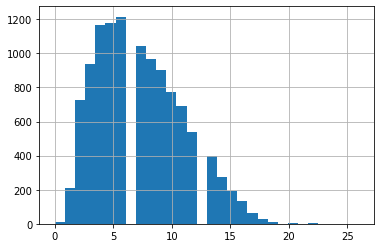

In [124]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
print("Mean length of sentence: ",np.mean(seq_len))
print("Max length of sentence: ",max (seq_len))

Tokeninzation and Encoding

In [56]:
#import tokenizer
from transformers import BertTokenizer

model_ckpt = "bert-base-uncased"
num_sentiment_labels = 2 #need to modify based on our dataset (positive, negative, neutral)

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_ckpt, do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [125]:
# tokenize and encode sequences in the training set, validation set and test set

max_length = 64

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True
)

In [126]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [151]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
prediction_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during testing
prediction_sampler = SequentialSampler(prediction_data)

# dataLoader for train set
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [129]:
#checking the tokenizer is working or not

# Print the original sentence.
print('Original: ', sentences[401])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[401]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[401])))

Original:  m sorry sick know they know guess pelzer present
Tokenized:  ['m', 'sorry', 'sick', 'know', 'they', 'know', 'guess', 'pe', '##lz', '##er', 'present']
Token IDs:  [1049, 3374, 5305, 2113, 2027, 2113, 3984, 21877, 23858, 2121, 2556]


In [130]:
#import the Classifier and train it
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    model_ckpt, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = num_sentiment_labels, # The number of output labels--2 for binary classification.You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [131]:
# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [132]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Optimizer & Learning Rate Scheduler

In [143]:
#Optimizer & Learning Rate Scheduler
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [144]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training Loop

In [145]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [146]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [147]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    358.    Elapsed: 0:00:15.
  Batch    80  of    358.    Elapsed: 0:00:28.
  Batch   120  of    358.    Elapsed: 0:00:41.
  Batch   160  of    358.    Elapsed: 0:00:55.
  Batch   200  of    358.    Elapsed: 0:01:08.
  Batch   240  of    358.    Elapsed: 0:01:22.
  Batch   280  of    358.    Elapsed: 0:01:35.
  Batch   320  of    358.    Elapsed: 0:01:48.

  Average training loss: 0.33
  Training epcoh took: 0:02:01

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.26
  Validation took: 0:00:09

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    358.    Elapsed: 0:00:13.
  Batch    80  of    358.    Elapsed: 0:00:27.
  Batch   120  of    358.    Elapsed: 0:00:40.
  Batch   160  of    358.    Elapsed: 0:00:53.
  Batch   200  of    358.    Elapsed: 0:01:07.
  Batch   240  of    358.    Elapsed: 0:01:20.
  Batch   280  of    358.    Elapsed: 0:01:33.
  Batch   320  of    358.    Elapsed: 0:01:46.

  Averag

In [148]:
#summary of the training process

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.33,0.26,0.9,0:02:01,0:00:09
2,0.21,0.29,0.9,0:01:59,0:00:09
3,0.14,0.33,0.9,0:01:59,0:00:09
4,0.10,0.39,0.9,0:01:59,0:00:09


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data.

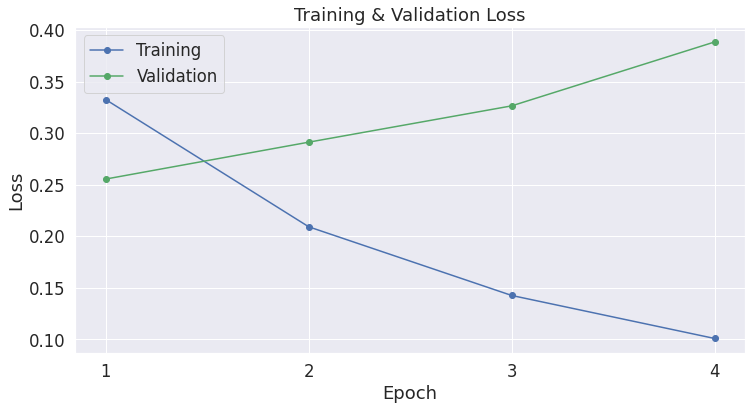

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Evaluate on Test Set

In [154]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_text)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,455 test sentences...
    DONE.


In [170]:
# model's performance

from sklearn.metrics import classification_report

print(classification_report(label_ids, logits))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.92      1.00      0.96        12

    accuracy                           0.96        23
   macro avg       0.96      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23

